# **Importing Necessary Libraries**

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
import random
import warnings
warnings.filterwarnings("ignore")

# **Downloading Both the Datasets - KDD Cup'99 and NSL-KDD**

In [3]:
# Define dataset URLs and file names
kdd_url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
kdd_file = "kddcup.data_10_percent.gz"

nsl_train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt"
nsl_test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"

nsl_train_file = "KDDTrain+.txt"
nsl_test_file = "KDDTest+.txt"

# Download datasets if they do not exist locally
if not os.path.exists(kdd_file):
    print("Downloading KDD Cup 10% dataset...")
    urlretrieve(kdd_url, kdd_file)

if not os.path.exists(nsl_train_file):
    print("Downloading NSL-KDD training dataset...")
    urlretrieve(nsl_train_url, nsl_train_file)

if not os.path.exists(nsl_test_file):
    print("Downloading NSL-KDD testing dataset...")
    urlretrieve(nsl_test_url, nsl_test_file)


 # **Pre-processing KDD Cup'99 Dataset**

In [4]:
# Define column names for the dataset
kdd_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]

# Load KDD dataset into a Pandas DataFrame
kdd_data = pd.read_csv(kdd_file, names=kdd_columns)

# Drop known redundant features
drop_cols = ["num_outbound_cmds"]  # This feature is known to be constant and provides no value
kdd_data.drop(drop_cols, axis=1, inplace=True)

# Convert categorical columns to numerical using One-Hot Encoding
categorical_cols = ["protocol_type", "service", "flag"]
kdd_data = pd.get_dummies(kdd_data, columns=categorical_cols, drop_first=True)

# Convert attack labels into binary values (0 for normal, 1 for attack)
kdd_data["label"] = kdd_data["label"].apply(lambda x: 0 if x == "normal." else 1)

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
numerical_cols = [col for col in kdd_data.columns if col != "label"]
kdd_data[numerical_cols] = scaler.fit_transform(kdd_data[numerical_cols])

# Split data into training and testing sets
X_kdd = kdd_data.drop("label", axis=1)  # Features
y_kdd = kdd_data["label"]  # Labels

X_train_kdd, X_test_kdd, y_train_kdd, y_test_kdd = train_test_split(
    X_kdd, y_kdd, test_size=0.2, random_state=42
)


# **Pre-processing NSL-KDD Dataset**

In [5]:
nsl_columns = kdd_columns + ["difficulty"]

nsl_train = pd.read_csv(nsl_train_file, names=nsl_columns)
nsl_test = pd.read_csv(nsl_test_file, names=nsl_columns)

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Convert categorical columns
for col in ["protocol_type", "service", "flag"]:
    nsl_train[col] = encoder.fit_transform(nsl_train[col])
    nsl_test[col] = encoder.transform(nsl_test[col])


# Map labels to binary
nsl_train["label"] = nsl_train["label"].apply(lambda x: 0 if x == "normal" else 1)
nsl_test["label"] = nsl_test["label"].apply(lambda x: 0 if x == "normal" else 1)

# Drop difficulty level column
nsl_train.drop(["difficulty"], axis=1, inplace=True)
nsl_test.drop(["difficulty"], axis=1, inplace=True)

# Separate features and labels
X_train_nsl = nsl_train.drop("label", axis=1)
y_train_nsl = nsl_train["label"]
X_test_nsl = nsl_test.drop("label", axis=1)
y_test_nsl = nsl_test["label"]

# Standardize data
X_train_nsl = scaler.fit_transform(X_train_nsl)
X_test_nsl = scaler.transform(X_test_nsl)


# **Building Random Forest from Scratch**

In [31]:
class RandomForestScratch(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_features="sqrt",
                 max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, class_weight=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.bootstrap = bootstrap
        self.trees = []

    def bootstrap_sample(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=self.bootstrap)
        y = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else y
        return X[indices, :], y[indices]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = DecisionTreeClassifier(
                max_features=self.max_features,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=self.class_weight
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return mode(tree_preds, axis=0)[0].flatten()

    def get_params(self, deep=True):
        return {
            "n_estimators": self.n_estimators,
            "max_features": self.max_features,
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf,
            "class_weight": self.class_weight
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def predict_proba(self, X):
        probas = [tree.predict_proba(X) for tree in self.trees]
        return np.mean(probas, axis=0)


# **Functions to find and plot performance metrics**

In [22]:
def plot_confusion_matrix(y_true, y_pred, title):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def evaluate(y_true, y_pred, title):
    print(f"{title} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    plot_confusion_matrix(y_true, y_pred, title)

def plot_roc_curve(y_true, y_scores, model_name, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} ({dataset_name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_f1_vs_classifiers(n_estimators_list, f1_scores_scratch, f1_scores_sklearn, dataset_name):
    plt.figure(figsize=(7, 5))
    plt.plot(n_estimators_list, f1_scores_scratch, marker='o', label='Scratch RF', color='blue')
    plt.plot(n_estimators_list, f1_scores_sklearn, marker='s', label='Sklearn RF', color='green')
    plt.xlabel('Number of Estimators')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs No. of Classifiers ({dataset_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

# **Training the RF Models(both from sklearn and from scratch) and Finding out the performance metrics on KDD Cup'99**

Scratch RF - KDD - 5 Estimators Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


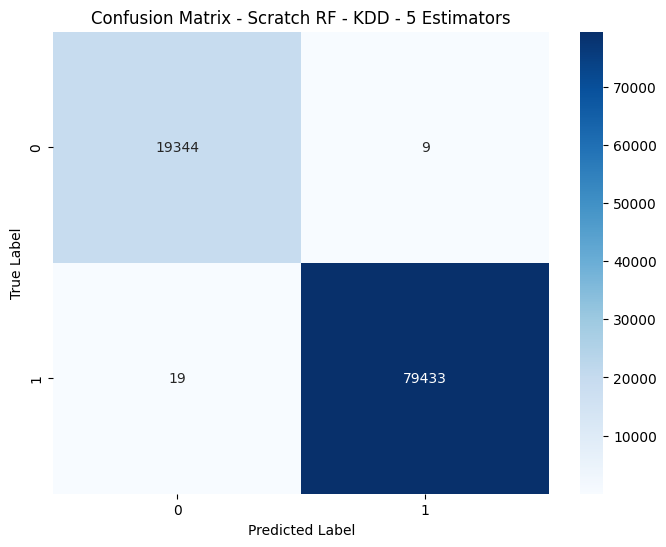

Sklearn RF - KDD - 5 Estimators Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


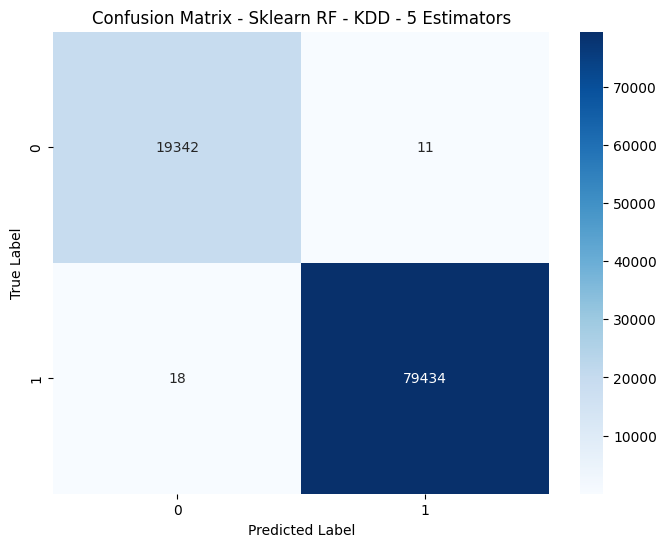

Scratch RF - KDD - 10 Estimators Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


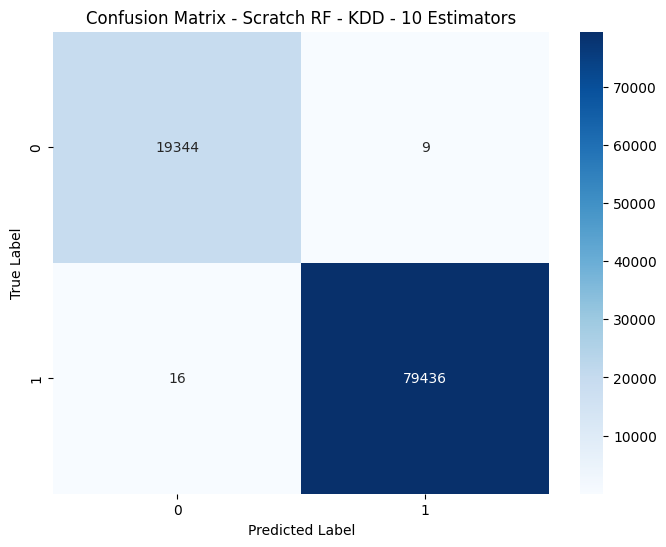

Sklearn RF - KDD - 10 Estimators Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


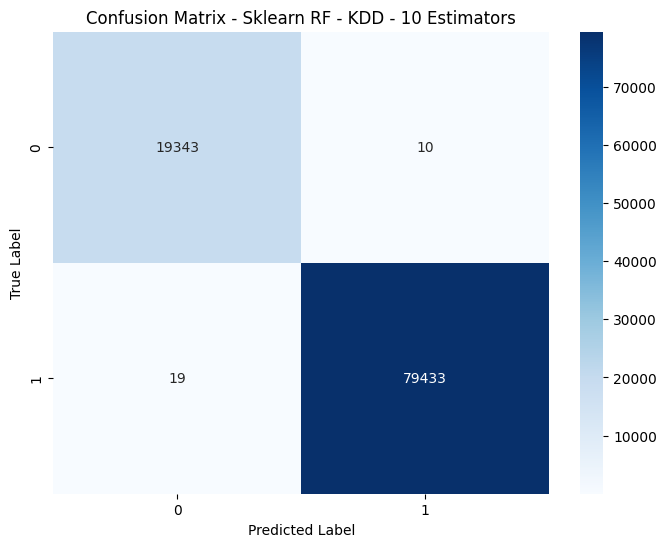

Scratch RF - KDD - 20 Estimators Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


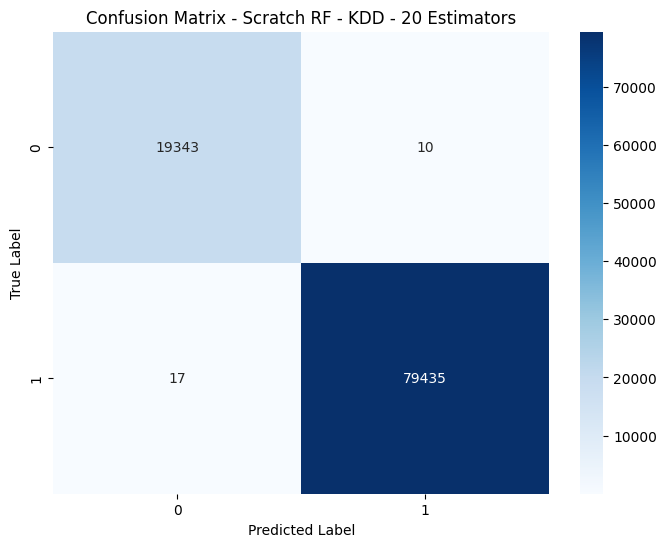

Sklearn RF - KDD - 20 Estimators Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


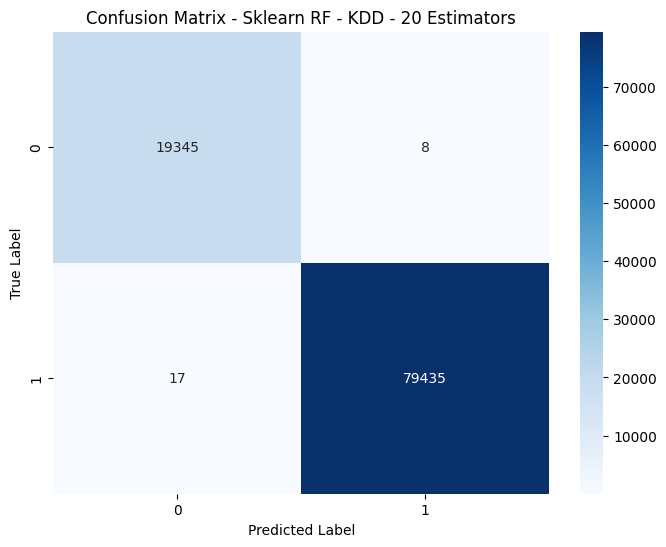

Scratch RF - KDD - 30 Estimators Performance:
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


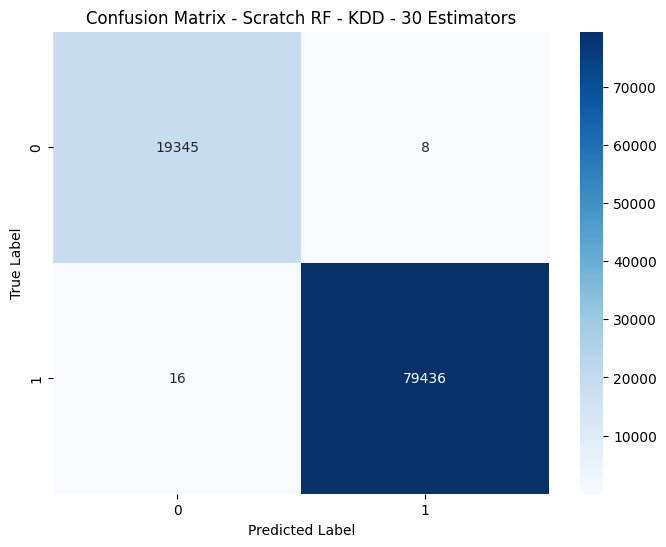

Sklearn RF - KDD - 30 Estimators Performance:
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


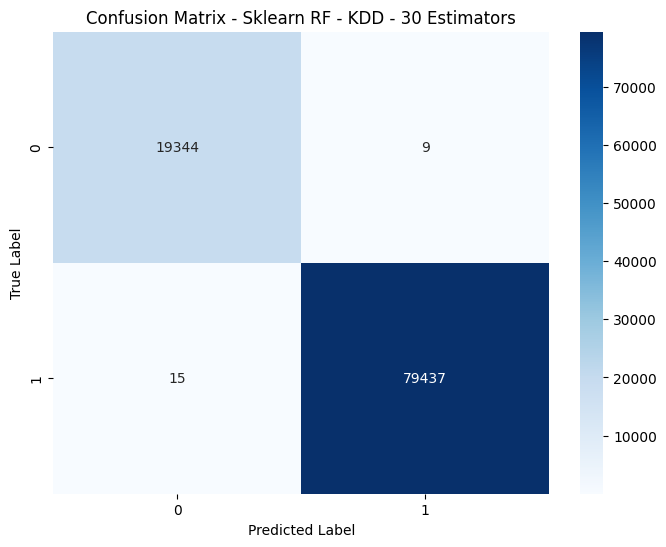

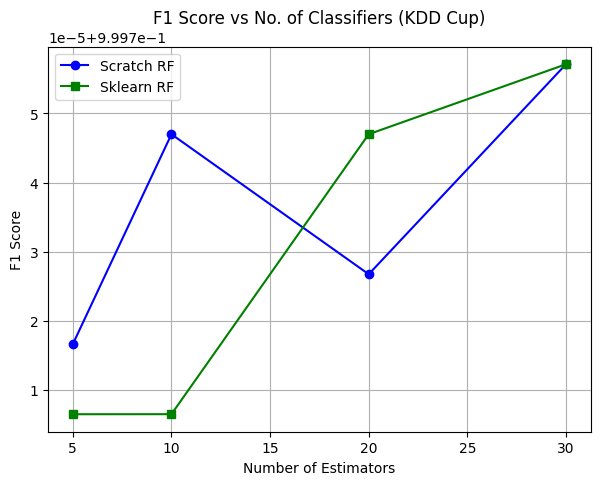

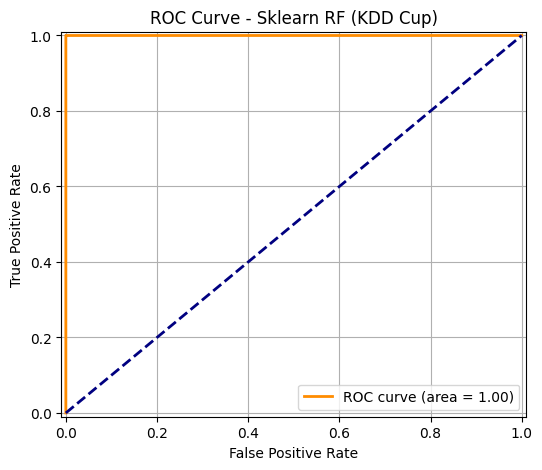

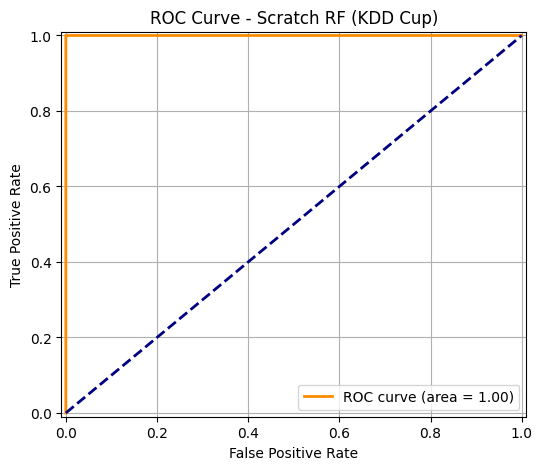

In [33]:
f1_scores_scratch_kdd = []
f1_scores_sklearn_kdd = []
n_estimators_list = [5, 10, 20, 30]

rf_sklearn = RandomForestClassifier(random_state=42)

for n in n_estimators_list:
    param_grid_temp = {
        'n_estimators': [n],
        'max_depth': [None],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'bootstrap': [True]
    }

    # Scratch RF
    rf_scratch = RandomForestScratch()
    grid_search = GridSearchCV(estimator=rf_scratch, param_grid=param_grid_temp, cv=3, n_jobs=5, verbose=0, scoring='accuracy')
    grid_search.fit(X_train_kdd, y_train_kdd)
    rf_best_scratch = grid_search.best_estimator_
    y_pred = rf_best_scratch.predict(X_test_kdd)
    evaluate(y_test_kdd, y_pred, f"Scratch RF - KDD - {n} Estimators")
    f1_scores_scratch_kdd.append(f1_score(y_test_kdd, y_pred, average='weighted'))

    # Sklearn RF
    grid_search = GridSearchCV(estimator=rf_sklearn, param_grid=param_grid_temp, cv=3, n_jobs=5, verbose=0, scoring='accuracy')
    grid_search.fit(X_train_kdd, y_train_kdd)
    rf_best_sklearn = grid_search.best_estimator_
    y_pred = rf_best_sklearn.predict(X_test_kdd)
    evaluate(y_test_kdd, y_pred, f"Sklearn RF - KDD - {n} Estimators")
    f1_scores_sklearn_kdd.append(f1_score(y_test_kdd, y_pred, average='weighted'))

# Plot
plot_f1_vs_classifiers(n_estimators_list, f1_scores_scratch_kdd, f1_scores_sklearn_kdd, dataset_name="KDD Cup")

# ROC Curve for sklearn RF
y_scores_kdd_sklearn = rf_best_sklearn.predict_proba(X_test_kdd)[:, 1]
plot_roc_curve(y_test_kdd, y_scores_kdd_sklearn, "Sklearn RF", "KDD Cup")

# ROC Curve for Scratch RF
y_scores_kdd_scratch = rf_best_sklearn.predict_proba(X_test_kdd)[:, 1]
plot_roc_curve(y_test_kdd, y_scores_kdd_scratch, "Scratch RF", "KDD Cup")

# **Training the RF Models(both from sklearn and from scratch) and Finding out the performance metrics on NSL-KDD**

Scratch RF - NSL - 5 Estimators Performance:
Accuracy: 0.7816
Precision: 0.9613
Recall: 0.6422
F1 Score: 0.7700


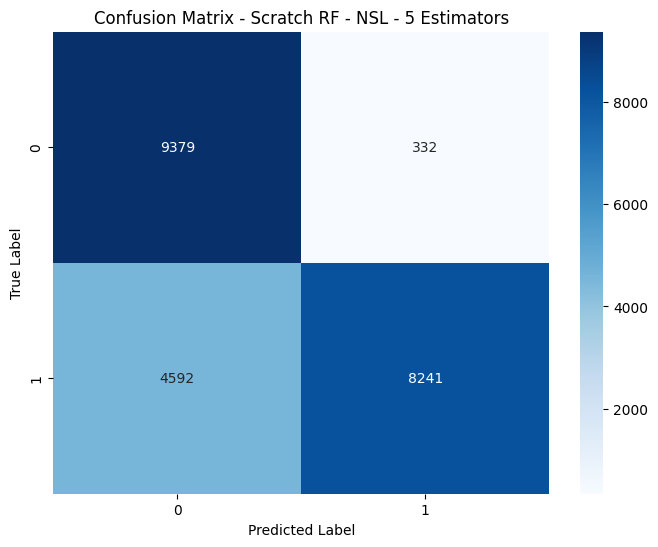

Sklearn RF - NSL - 5 Estimators Performance:
Accuracy: 0.7857
Precision: 0.9686
Recall: 0.6444
F1 Score: 0.7739


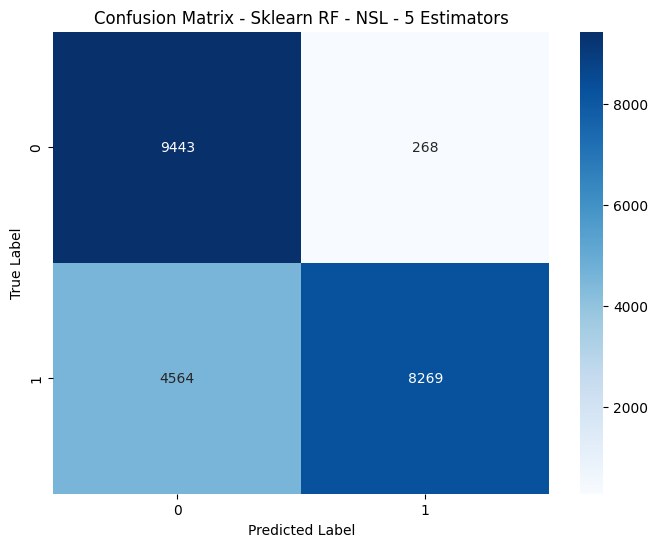

Scratch RF - NSL - 10 Estimators Performance:
Accuracy: 0.7580
Precision: 0.9643
Recall: 0.5970
F1 Score: 0.7374


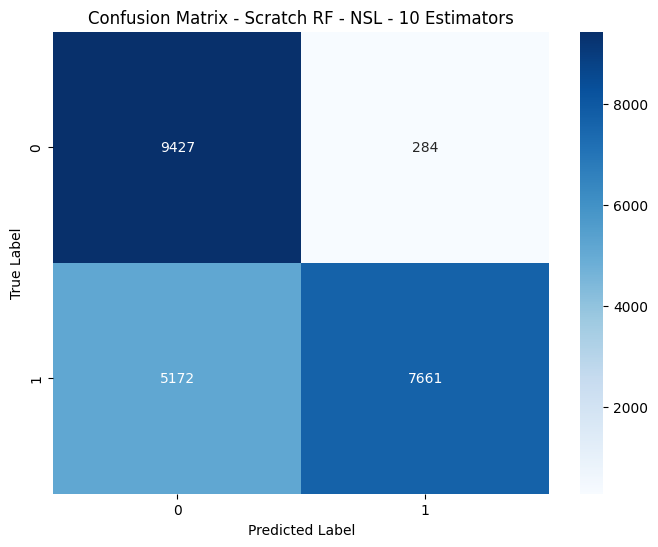

Sklearn RF - NSL - 10 Estimators Performance:
Accuracy: 0.7688
Precision: 0.9670
Recall: 0.6148
F1 Score: 0.7517


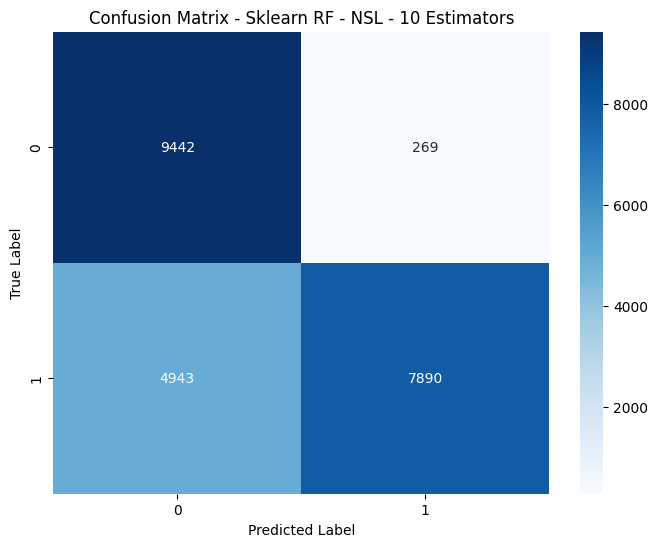

Scratch RF - NSL - 20 Estimators Performance:
Accuracy: 0.7708
Precision: 0.9665
Recall: 0.6188
F1 Score: 0.7545


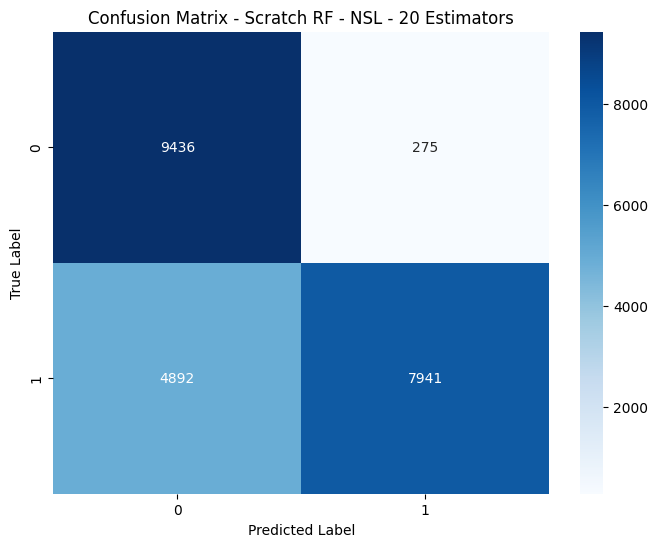

Sklearn RF - NSL - 20 Estimators Performance:
Accuracy: 0.7755
Precision: 0.9666
Recall: 0.6273
F1 Score: 0.7608


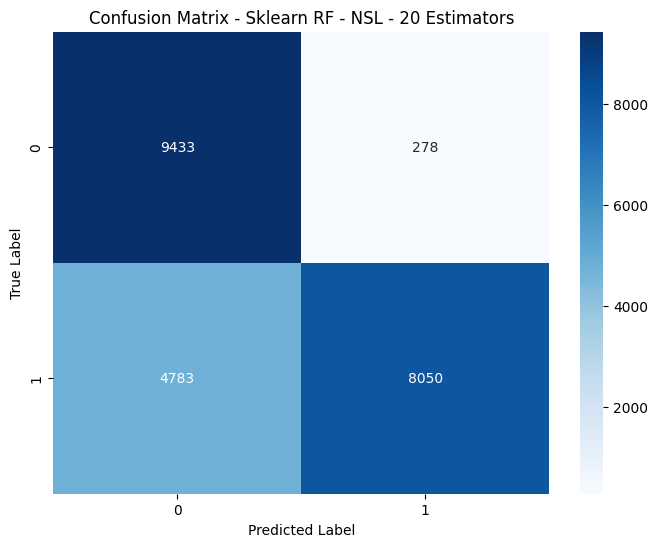

Scratch RF - NSL - 30 Estimators Performance:
Accuracy: 0.7677
Precision: 0.9662
Recall: 0.6133
F1 Score: 0.7503


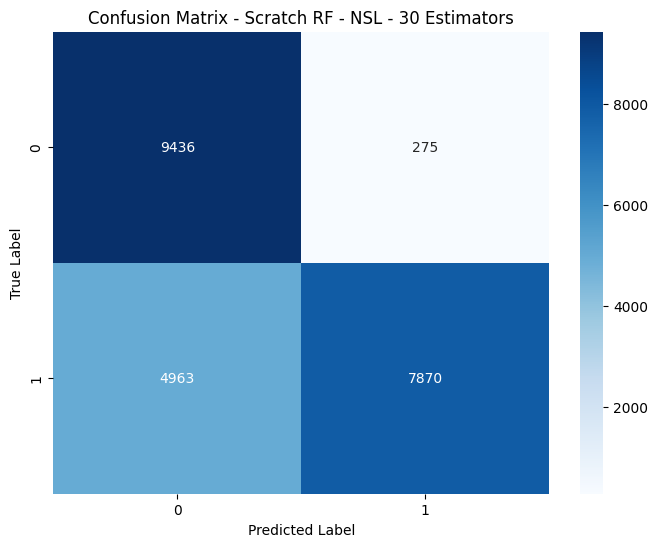

Sklearn RF - NSL - 30 Estimators Performance:
Accuracy: 0.7763
Precision: 0.9665
Recall: 0.6288
F1 Score: 0.7619


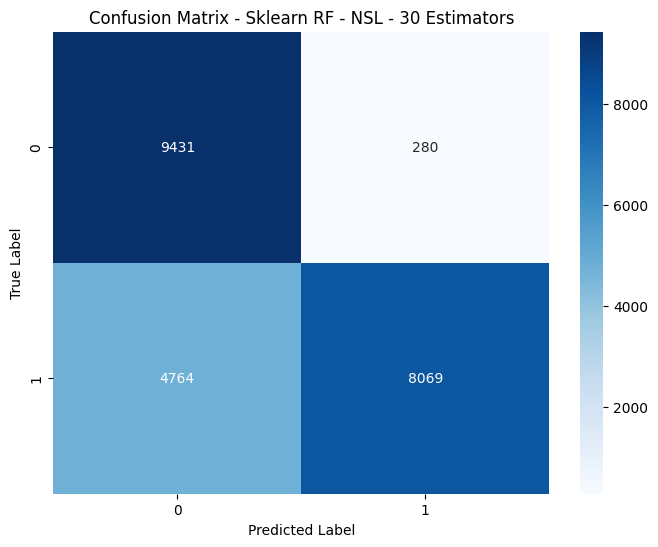

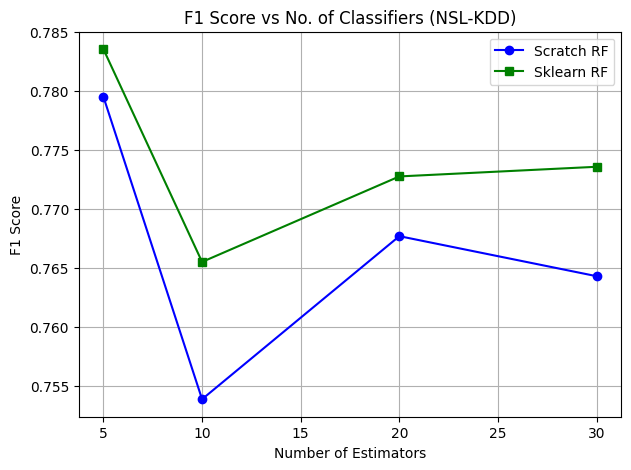

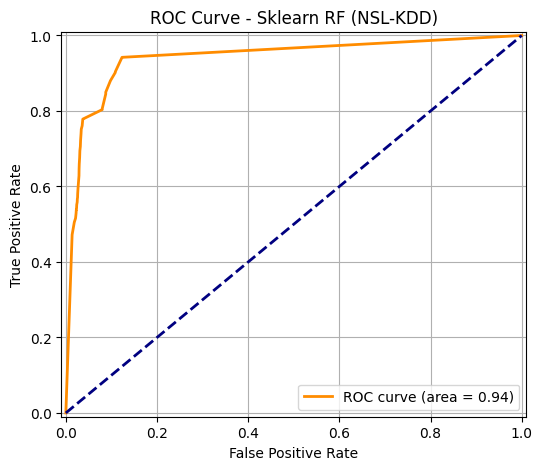

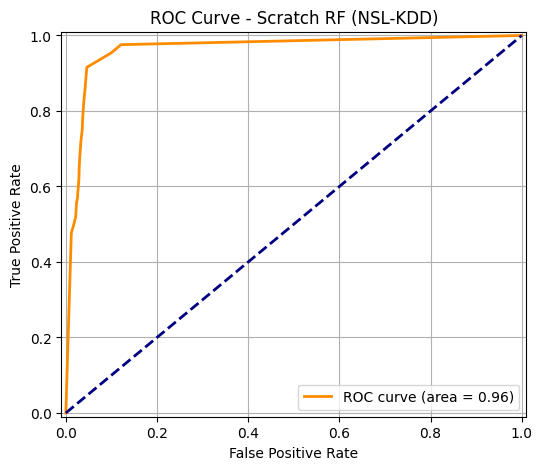

In [32]:
f1_scores_scratch_nsl = []
f1_scores_sklearn_nsl = []

for n in n_estimators_list:
    param_grid_temp = {
        'n_estimators': [n],
        'max_depth': [None],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'bootstrap': [True]
    }

    # Scratch RF
    rf_scratch = RandomForestScratch()
    grid_search = GridSearchCV(estimator=rf_scratch, param_grid=param_grid_temp, cv=3, n_jobs=5, verbose=0, scoring='accuracy')
    grid_search.fit(X_train_nsl, y_train_nsl)
    rf_best_scratch = grid_search.best_estimator_
    y_pred = rf_best_scratch.predict(X_test_nsl)
    evaluate(y_test_nsl, y_pred, f"Scratch RF - NSL - {n} Estimators")
    f1_scores_scratch_nsl.append(f1_score(y_test_nsl, y_pred, average='weighted'))

    # Sklearn RF
    rf_sklearn = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf_sklearn, param_grid=param_grid_temp, cv=3, n_jobs=5, verbose=0, scoring='accuracy')
    grid_search.fit(X_train_nsl, y_train_nsl)
    rf_best_sklearn = grid_search.best_estimator_
    y_pred = rf_best_sklearn.predict(X_test_nsl)
    evaluate(y_test_nsl, y_pred, f"Sklearn RF - NSL - {n} Estimators")
    f1_scores_sklearn_nsl.append(f1_score(y_test_nsl, y_pred, average='weighted'))

# Plot
plot_f1_vs_classifiers(n_estimators_list, f1_scores_scratch_nsl, f1_scores_sklearn_nsl, dataset_name="NSL-KDD")

# ROC Curve for sklearn RF
y_scores_nsl_sklearn = rf_best_sklearn.predict_proba(X_test_nsl)[:, 1]
plot_roc_curve(y_test_nsl, y_scores_nsl_sklearn, "Sklearn RF", "NSL-KDD")

# ROC Curve for Scratch RF
y_scores_nsl_scratch = rf_best_scratch.predict_proba(X_test_nsl)[:, 1]
plot_roc_curve(y_test_nsl, y_scores_nsl_scratch, "Scratch RF", "NSL-KDD")